# Random Walks

**September 08 2020**  
*Vincenzo Perri*

In this notebook unit we explore random walks, a simple yet powerful stochastic model for diffusion processes in networks. Random walk processes are not only important as a model for diffusion. Their stationary distribution can also be used to define centrality measures based on the eigenvectors of the transition matrix. Studying both the stationary state as well as the speed of diffusion processes:

In [1]:
import pathpy as pp
import numpy as np
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')
sns.set_style("whitegrid")
    
from numpy import linalg as npl
import scipy as sp

In [2]:
n = pp.Network(directed=True)
n.add_edge('a', 'b', weight=2)
n.add_edge('a', 'c', weight=1)
n.add_edge('b', 'c', weight=1)
n.add_edge('b', 'a', weight=2)
n.add_edge('c', 'a', weight=5)
n.plot()

## Transition matrices


`pathpy` provides a function that computes a (row- or right-stochastic) transition matrix of a random walk process for a given network. The method should work for weighted, unweighted, directed, and undirected networks represented by a `pathpy.Network` object.

In [3]:
pp.algorithms.transition_matrix(n, weight = "weight").todense()

matrix([[0.        , 0.66666667, 0.33333333],
        [0.66666667, 0.        , 0.33333333],
        [1.        , 0.        , 0.        ]])

Write a function that computes the visitation probability $\pi^{(t)}$ of a random walk after $t$ steps, based on a given initial distribution $\pi^{(0)}$ and a given network topology. You can use built-in `numpy` functions for matrix powers and matrix multiplication. For matrix multiplication, you should have a look at the `dot` function in `numpy`. For the calculation of matrix powers, you should look into the package `numpy.linalg`.

In [4]:
def visitation_probabilities(network, initial_dist, t):
    T = pp.algorithms.transition_matrix(network, weight="weight").todense()
    p_t = np.dot(initial_dist, npl.matrix_power(T,t))
    return p_t

In [5]:
print("zeroth step: {}".format(visitation_probabilities(n, np.array([1, 0, 0]), 0)))
print("zerotfirst step: {}".format(visitation_probabilities(n, np.array([1, 0, 0]), 1)))
print("five hundreth step: {}".format(visitation_probabilities(n, np.array([1, 0, 0]), 500)))

zeroth step: [[1. 0. 0.]]
zerotfirst step: [[0.         0.66666667 0.33333333]]
five hundreth step: [[0.45 0.3  0.25]]


We can compute the stationary distribution of the random walk:

In [6]:
def stationary_distribution(network):
    T =  pp.algorithms.transition_matrix(network).todense()
    eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
    # Here we take the **leading eigenvector**, i.e. the eigenvector
    # corresponding to the **largest eigenvalue** of one
    # numpy.argsort returns an array of indices that would sort an array
    # note the multi-dimensional slicing :,x, which returns all entries 
    # in column x
    pi = eigenvectors[:,np.argsort(-eigenvalues)][:,0]

    # We make sure that the eigenvector is normalised
    pi = pi/sum(pi)
    return pi

In [7]:
stationary_distribution(n)

array([0.44444444-0.j, 0.22222222-0.j, 0.33333333-0.j])

Generate a connected, undirected example network with $10$ nodes and $15$ links and test your function by computing the visitation probabilities after $t=10$ and $t=100$ steps for different initial distributions. 

Do the visitation probabilities converge to a stationary distribution? How do the visitation probabilities after $100$ steps differ across different initial distributions?

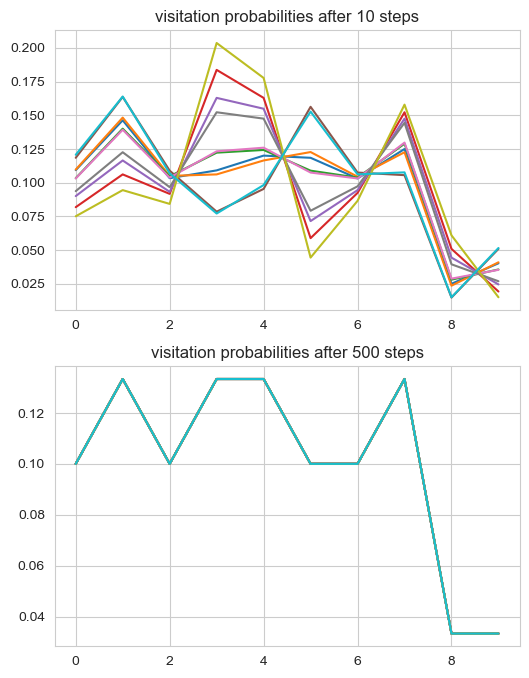

In [8]:
er_net = pp.generators.random_graphs.ER_nm(n = 10, m = 15)

pp.algorithms.components.largest_connected_component(er_net)
n = er_net.number_of_nodes()

fig, ax = plt.subplots(nrows=2, figsize = [6,8])
for i in range(n):
    initial_dist = [0]*n
    initial_dist[i] = 1
    pi = visitation_probabilities(er_net, initial_dist, 10)
    ax[0].set_title("visitation probabilities after 10 steps")
    ax[0].plot(np.array(pi).ravel())
    pi = visitation_probabilities(er_net, initial_dist, 500)
    ax[1].set_title("visitation probabilities after 500 steps")
    ax[1].plot(np.array(pi).ravel())
    print()

## Random walks in `pathpy`

`pathpy` offers direct support for the simulation of random walk processes in a network, as well as for the calculation of transition matrices, stationary states and total variation distance. To initialise a new random walk process in a given network, we can write:

In [9]:
n = pp.Network(directed=True)
n.add_edge('a', 'b', weight=2)
n.add_edge('a', 'c', weight=1)
n.add_edge('b', 'c', weight=1)
n.add_edge('b', 'a', weight=2)
n.add_edge('c', 'a', weight=5)
n.plot()

In [10]:
rw = pp.processes.RandomWalk(n, start_node='a', weight=True)

c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


If we omit the parameter `start_node` the initial node will be chosen uniformly at random among all nodes in the network. At any point, we can print the current time (i.e. number of steps taken so far), the current steps, and the current visitation probabilities as follows:

In [11]:
print(rw.t)

0


In [12]:
print(rw.state)

a


In [13]:
print(rw.visitation_frequencies())

[1. 0. 0.]


In [14]:
print(rw.stationary_probabilities())

[0.45 0.3  0.25]


In [15]:
print(rw.total_variation_distance)

0.5499999999999998


Calling the function `transition` makes a single transition, which updates the time, state, and visitation frequencies of the random walk. The transition method returns the node that is visited:

In [16]:
x = rw.transition()
print('Random walker is in node =', rw.state)
print('Current time =', rw.t)
print('Current visitation_frequencies =', rw.visitation_frequencies())

Random walker is in node = b
Current time = 1
Current visitation_frequencies = [0.5 0.5 0. ]


In [17]:
rw.total_variation_distance

0.24999999999999994

In [18]:
print(rw.visitation_probabilities(t=1, start_node='a'))

[[0.         0.66666667 0.33333333]]


In [19]:
for v in rw.walk(10000):
    pass

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2152.18it/s]


In [20]:
print(rw.visitation_frequencies())

[0.45001    0.29514097 0.25484903]


In [21]:
rw.total_variation_distance

0.004859028194361029

# Diffusion Speed in Networks


In the second section we study the speed of diffusion in different network topologies. We use experiments to test the analytical predictions that we developed in the theory lecture. 

### Total Variation Distance

To calculate diffusion speed, we first write a function that computes the total variation distance between two stochastic vectors $\pi$ and $\pi'$.

In [22]:
def tvd(p1, p2):
    assert len(p1) == len(p2)
    tvd = 0
    for i in range(len(p1)):
        tvd +=abs(p1[i] - p2[i])
    return tvd/2

The following helper function returns the total variation distances between the stationary distribution $\pi$ and the visitation probability $\pi^s$ for $s=0, \ldots, t$ steps of a random walk process.

In [23]:
def compute_tvd(network, t, epsilon=0.005):

    t_min = np.inf
    
    T = pp.processes.RandomWalk.transition_matrix(network).todense()
    
    # We use a **right-stochastic matrix**, so what we want to
    # compute is the **left** eigenvectors (see lecture L08)
    eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
    
    # Here we take the **leading eigenvector**, i.e. the eigenvector
    # corresponding to the **largest eigenvalue** of one
    # numpy.argsort returns an array of indices that would sort an array
    # note the multi-dimensional slicing :,x, which returns all entries 
    # in column x
    pi = eigenvectors[:,np.argsort(-eigenvalues)][:,0]
    
    # We make sure that the eigenvector is normalised
    pi = pi/sum(pi)

    # We set the initial distribution
    initial_dist = np.array([0]*network.number_of_nodes())
    initial_dist[0] = 1

    # We calculate the total variation dist after each step
    tvds = []
    for s in range(t):
        x = np.ravel(np.dot(initial_dist, np.linalg.matrix_power(T, s)))
        d = tvd(pi,x)
        if d <= epsilon and t_min > s:
            t_min = s
        tvds.append(d)
    return tvds, t_min

We use the function above to calculate and plot the evolution of the total variation distance for the undirected example network shown in lecture 08.

c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


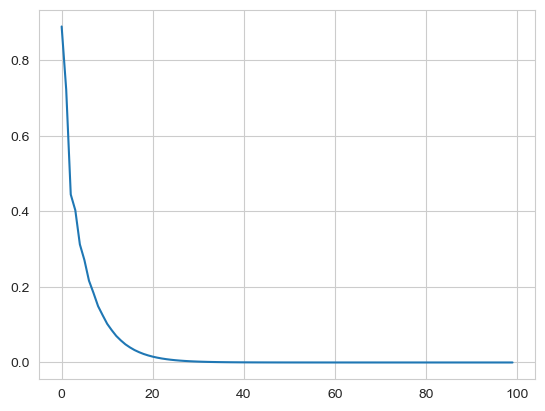

In [24]:
n = pp.Network(directed=False)
n.add_edge('a', 'b')
n.add_edge('b', 'c')
n.add_edge('a', 'c')
n.add_edge('b', 'd')
n.add_edge('d', 'f')
n.add_edge('d', 'g')
n.add_edge('d', 'e')
n.add_edge('e', 'f')
n.add_edge('f', 'g')
n.plot()

d, tmin = compute_tvd(n, 100, epsilon=0.05)
plt.plot(np.arange(100), d)

In [25]:
print('t_min =', tmin)

t_min = 14


In [26]:
def lambda_2(network):
    T = pp.processes.RandomWalk.transition_matrix(network).todense()
    eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
    x = eigenvalues[np.argsort(-eigenvalues)]
    return np.abs(x[1])

In [27]:
print('prediction =', np.log(0.05)/np.log(lambda_2(n)))

prediction = 15.780738151107203


c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


## Network Topology and Diffusion Speed

Using code from previous exercises or corresponding `pathpy` functions, we now generate six different types of random networks:

   1. an Erdös-Renyi network with $n=200$ nodes and $m=400$ links
   2. an Erdös-Renyi network with $n=200$ nodes and $m=600$ links
   3. a modular network consisting of two $5$-regular random networks with $50$ nodes each, which are joined together by crossing the endpoints of two arbitrary chosen links
   5. a Watts-Strogatz ring lattice with the parameters $n=200$, $m=5$ and rewiring probability $p=0$
   6. a Watts-Strogatz small-world network with the parameters $n=200$, $m=5$ and rewiring probability $p=0.05$

For each of the six networks we use the function from above to compute the evolution of total variation distance $\delta(\pi^{(t)}, \pi)$ for $t \in \left[0, 500\right]$ where $\pi$ is the stationary distribution.

### Experiment 1: Erdös-Renyi network with 100 nodes and 200 links

c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


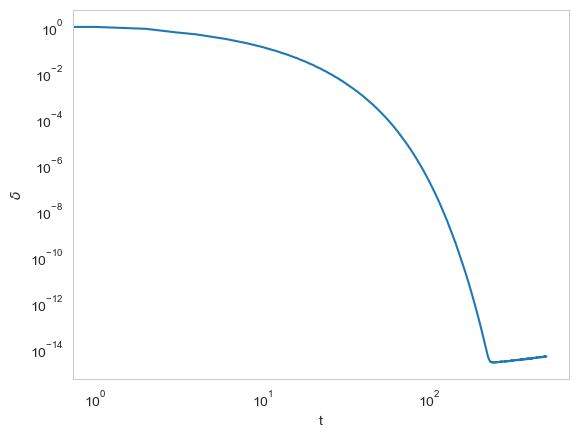

In [28]:
er_1 = pp.generators.random_graphs.ER_nm(n=100, m=200)
er_1 = pp.algorithms.components.largest_connected_component(er_1)

d, tmin = compute_tvd(er_1, 500)

plt.clf()
plt.grid()
plt.loglog(np.arange(500), d)
plt.xlabel("t")
plt.ylabel(r"$\delta$")
plt.show()

In [29]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(er_1))))

t_min = 29


c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


prediction = 37.309204171542795


### Experiment 2: Erdös-Renyi network with 100 nodes and 300 links

c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


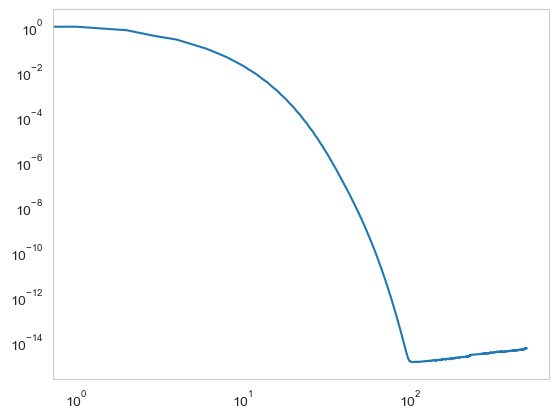

In [30]:
er_2 = pp.generators.random_graphs.ER_nm(n=100, m=300)
er_2 = pp.algorithms.components.largest_connected_component(er_2)

d, tmin = compute_tvd(er_2, 500)

plt.clf()
plt.grid()
plt.loglog(np.arange(500), d)
plt.show()

In [31]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(er_2))))

t_min = 13


c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


prediction = 13.972497870773788


### Experiment 3: Modular network consisting of two 5-regular random networks with a total of 100 nodes

c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


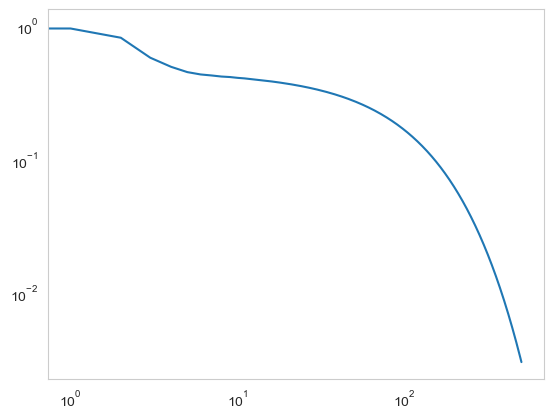

In [32]:
regular_1 = pp.generators.random_graphs.Molloy_Reed([5]*50, node_uids=[str(i) for i in range(50)])
regular_2 = pp.generators.random_graphs.Molloy_Reed([5]*50, node_uids=[str(i) for i in range(50,100)])
modular = regular_1 + regular_2

e1 = list(modular.edges)[1]
e2 = list(modular.edges)[200] 

modular.remove_edge(e1.v, e1.w)
modular.remove_edge(e2.v, e2.w)
modular.add_edge(e1.v, e2.w)
modular.add_edge(e2.v, e1.w)

d, tmin = compute_tvd(modular, 500)

plt.clf()
plt.grid()
plt.loglog(range(500), d)
plt.show()

In [ ]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(modular))))

t_min = 449


c:\users\vince\anaconda3\envs\devenv\lib\site-packages\scipy\sparse\_index.py:84: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


### Experiment 5: A Watts-Strogatz ring lattice with n=100, m=5 and p=0. 

In [ ]:
ring = pp.generators.random_graphs.Watts_Strogatz(n = 100, s = 5, p = 0)

d, tmin = compute_tvd(ring, 500)

plt.clf()
plt.grid()
plt.loglog(range(500), d)
plt.show()

In [ ]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(ring))))

### Network 6: A Watts-Strogatz small-world network with n = 100, m=5 and p = 0.05

In [ ]:
ws = pp.generators.random_graphs.Watts_Strogatz(n = 100, s = 5, p = 0.05)

d, tmin = compute_tvd(ws, 500)

plt.clf()
plt.grid()
plt.loglog(range(500), d)
plt.show()

In [ ]:
print('t_min =', tmin)
print('prediction =', np.abs(np.log(0.005)/np.log(lambda_2(ws))))

### Interpretation of results

We make the following observations: 

1. In a random network, the network with more links (quite expectedly) leads to faster diffusion than the network with fewer links. Moreover, the random network with 300 links gives rise to the **fastest diffusion**, across the studied network topologies.  
2. In the network with 100 nodes and two modules, diffusion is orders of magnitude (!) slower than in a random network.  
3. In the network with two modules, we see an interesting plateau in the evolution of the total variation distance, which is related to the presence of the two communities.  
5. In the ring topology ($p=0$), **diffusion is the slowest (comparable to the modular network)**.  
6. Randomly rewiring $5 \%$ of the links increases diffusion speed.